# HOT and LOT Region Sequence Generation

The following cell defines the file names and parameters.
- **sequence** specifies the corresponding genome for the HOT region data
- **hot_regions** specifies the input file containing the start and end points each HOT region
- **output_hot** specifies the name for the output file for HOT region sequences
- **output_lot** specifies the name for the output file for LOT region sequences
- **multiplier** denotes the percentage of LOT regions to generate with respect to the number of HOT regions

In [1]:
sequence = './genomes/male.hg19.fa'
hot_regions = 'maphot_hs_selection_reg_cx_denP01_all.bed'
output_hot = 'sshot_regions_05_any.fa'
output_lot = 'sslot_regions_05_any.fa'

multiplier = 1

The following cell includes all imports used in this notebook.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from Bio import SeqIO

The following cell converts the genome file to a dictionary with chromosome keys mapping to their corresponding base pair sequences.

In [3]:
record_dict = SeqIO.to_dict(SeqIO.parse(sequence, "fasta"))

The following cell parses the .bed file and saves the relevant information into a list:
- **line[0]** - chromosome number
- **line[1]** - start position (inclusive)
- **line[2]** - end position (exclusive)
- **line[3]** - HOT region name

In [4]:
with open(hot_regions) as f:
    lines = f.readlines()
    lines = [line.rstrip().split()[0:4] for line in lines]

# \#TODO - Inverse Transform Sampling for LOT regions

The following cell calculates and plots the distribution of HOT region sequence lengths.

Text(0, 0.5, 'Frequency')

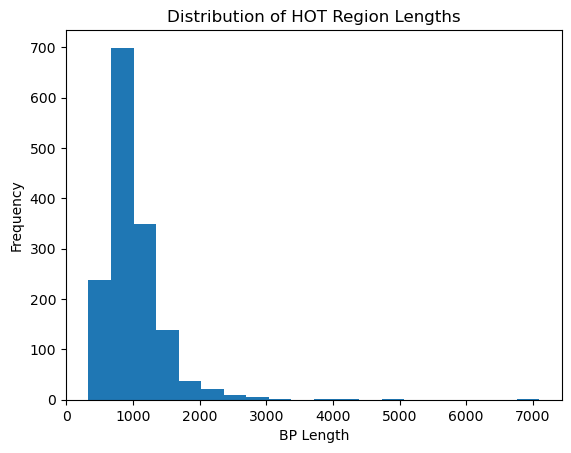

In [5]:
sizes = []
for entry in lines:
    sizes.append(int(entry[2]) - int(entry[1]))
arr = np.array(sizes)

plt.hist(arr, bins=20)
plt.title('Distribution of HOT Region Lengths')
plt.xlabel('BP Length')
plt.ylabel('Frequency')

The following cell first finds all the available LOT region index ranges (Logical inverse of HOT region index ranges) and then randomly generates LOT regions through inverse transform sampling on HOT region lengths **(still need todo)**.

In [6]:
index = '0'
curr_chromosome = 'chr1'
negative_set_indices = []

# Looping over chromosomes to find LOT region index ranges
for entry in lines:
    if entry[0] != curr_chromosome:
        negative_set_indices.append([curr_chromosome, index, len(record_dict[curr_chromosome].seq)])
        index = '0'
        curr_chromosome = entry[0]
    negative_set_indices.append([curr_chromosome, index, entry[1]])
    index = entry[2]
    
negative_set_indices_resized = []

# Iterating over possible ranges to get LOT regions
for x in negative_set_indices:
    curr_set = set()
    # Random size from HOT region distribution
    l = random.choice(sizes)
    # Ensuring that the region is long enough to sample from
    if int(x[2])-l < int(x[1]):
        continue
    num = min(multiplier,(int(x[2])-int(x[1]))//10)
    for _ in range(num):
        a = random.randint(int(x[1]), int(x[2])-l)
        # Ensuring nonoverlapping samples
        while any(a>=i and a<= i+l for i in curr_set):
            a = random.randint(int(x[1]), int(x[2])-l)
        curr_set.add(a)
    lis = sorted(list(curr_set))
    for y in lis:
        negative_set_indices_resized.append([x[0], str(y), str(y+l)])

In [7]:
# Printing HOT region indices, LOT region indices, and LOT region resized indices
df1 = pd.DataFrame(lines, columns = ['Chromosome', 'Start', 'End', 'Name'])
display(df1)
df2 = pd.DataFrame(negative_set_indices, columns = ['Chromosome', 'Start', 'End'])
display(df2)
df3 = pd.DataFrame(negative_set_indices_resized, columns = ['Chromosome', 'Start', 'End'])
display(df3)

,Chromosome,Start,End,Name
0,chr1,713833,714630,HOT.1
1,chr1,1310314,1311127,HOT.2
2,chr1,1342274,1343070,HOT.3
3,chr1,1446928,1447645,HOT.4
4,chr1,2322629,2323518,HOT.5
...,...,...,...,...
1500,chrX,70751839,70753184,HOT.1501
1501,chrX,73163773,73164664,HOT.1502
1502,chrX,77165593,77166326,HOT.1503
1503,chrX,118699004,118699700,HOT.1504


,Chromosome,Start,End
0,chr1,0,713833
1,chr1,714630,1310314
2,chr1,1311127,1342274
3,chr1,1343070,1446928
4,chr1,1447645,2322629
...,...,...,...
1522,chrX,21858102,70751839
1523,chrX,70753184,73163773
1524,chrX,73164664,77165593
1525,chrX,77166326,118699004


,Chromosome,Start,End
0,chr1,295299,296201
1,chr1,1165448,1166244
2,chr1,1311978,1313318
3,chr1,1372334,1373143
4,chr1,1845712,1847091
...,...,...,...
1508,chrX,30171093,30171919
1509,chrX,72148330,72150029
1510,chrX,75759628,75760675
1511,chrX,82997938,82999086


In [8]:
# Looking up base pair sequence coordinates and building output file contents

# Building HOT Regions fasta file
hot = ''
for entry in lines:
    sequence = str(record_dict[entry[0]][int(entry[1]):int(entry[2])].seq)
    # Removing any newlines from stored genome entry
    sequence_no_newline = sequence.replace('\n', '')
    hot = hot + '>' + entry[3] + '\n' + sequence_no_newline + '\n'
# Stripping last newline of file
hot =  hot.rstrip('\n') 
with open(output_hot,'w+') as f:
    f.write(hot)
    
# Building LOT Regions fasta file
lot = ''
i = 1
for entry in negative_set_indices_resized:
    sequence = str(record_dict[entry[0]][int(entry[1]):int(entry[2])].seq)
    # Removing any newlines from stored genome entry
    sequence_no_newline = sequence.replace('\n', '')
    lot = lot + '>LOT.' + str(i) + '\n' + sequence_no_newline + '\n'
    i += 1
# Stripping last newline of file
lot =  lot.rstrip('\n') 
with open(output_lot,'w+') as f:
    f.write(lot)